In [18]:
import os
import re
import warnings
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt

plt.style.use('Estilo/toutl.mplstyle')
from style import *


In [13]:
pip install colour

Note: you may need to restart the kernel to use updated packages.


In [15]:
df = pd.read_csv('Datos/examen3.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   client_stayed             10127 non-null  int64  
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

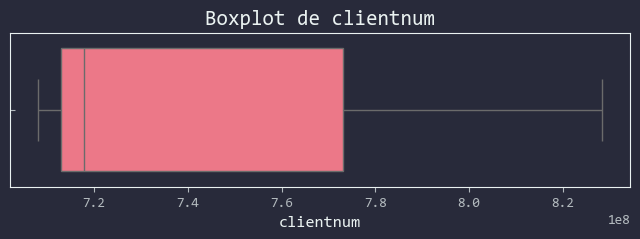

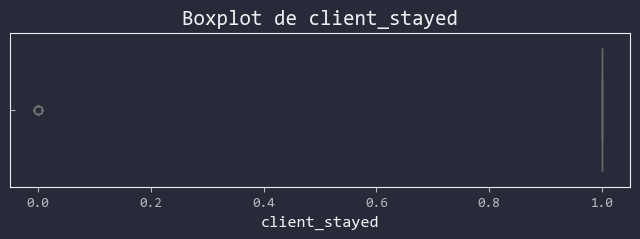

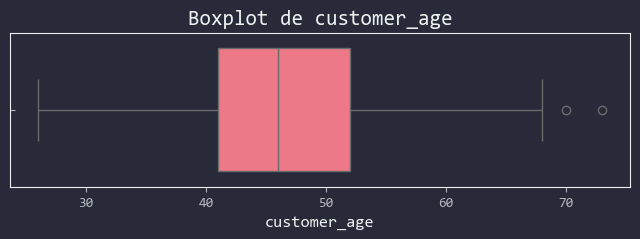

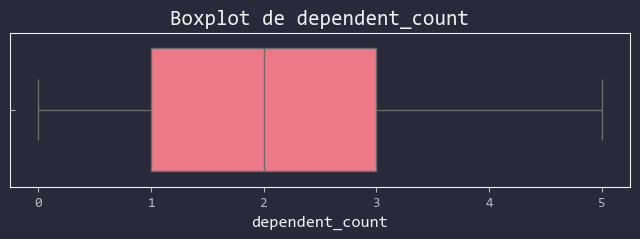

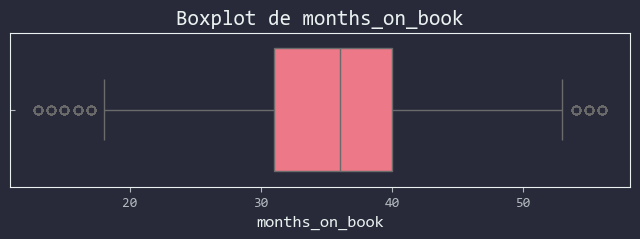

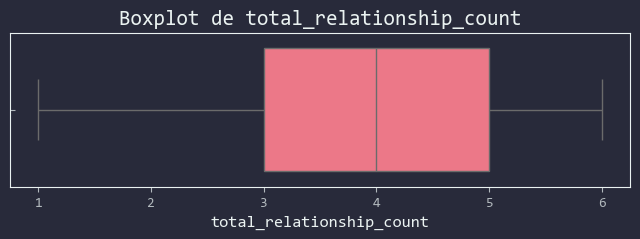

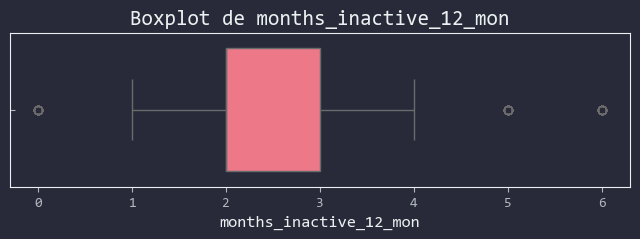

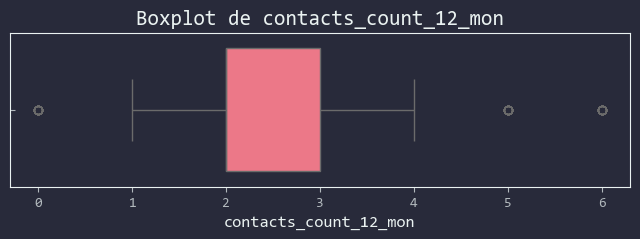

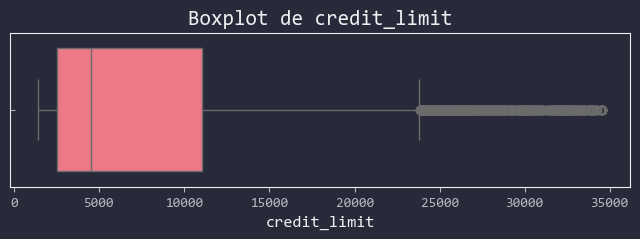

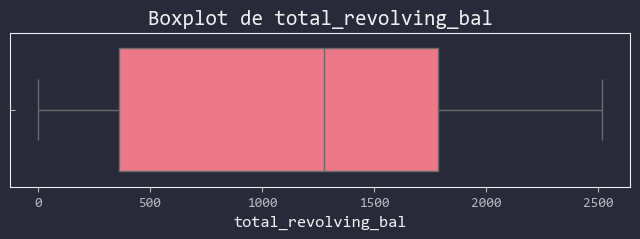

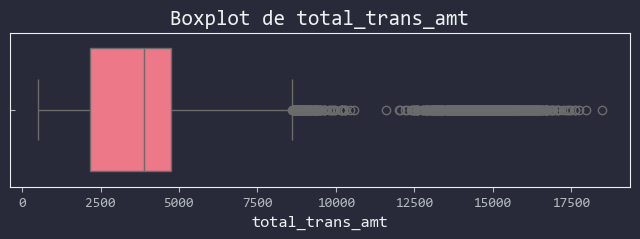

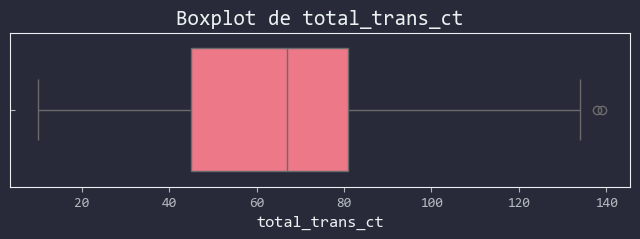

In [20]:
for col in df.columns:
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        plt.figure(figsize=(8, 2))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.xlabel(f'{col}')
        plt.show()
    else:
        continue

In [57]:
columna = "customer_age"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para customer_age:", outliers.shape[0])

columna = "months_on_book"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para months_on_book:", outliers.shape[0])

columna = "months_inactive_12_mon"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para months_inactive_12_mon:", outliers.shape[0])

columna = "contacts_count_12_mon"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para contacts_count_12_mon:", outliers.shape[0])

columna = "credit_limit"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para credit_limit:", outliers.shape[0])

columna = "total_trans_amt"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para total_trans_amt:", outliers.shape[0])

columna = "total_trans_ct"

Q1 = df[columna].quantile(0.25)
Q3 = df[columna].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]


print("Número de outliers para total_trans_ct:", outliers.shape[0])

df.dtypes

Número de outliers para customer_age: 2
Número de outliers para months_on_book: 386
Número de outliers para months_inactive_12_mon: 331
Número de outliers para contacts_count_12_mon: 629
Número de outliers para credit_limit: 984
Número de outliers para total_trans_amt: 896
Número de outliers para total_trans_ct: 2


clientnum                     int64
client_stayed                 int64
customer_age                  int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
income_category              object
card_category                object
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
contacts_count_12_mon         int64
credit_limit                float64
total_revolving_bal           int64
total_trans_amt               int64
total_trans_ct                int64
dtype: object

In [69]:
#Revisaremos el tipo de variables que tenemos en el dataframe para saber que tipo de imputacion harémos para cada colummna
#Revisamos en el dataframe:
df.head(10)
###Primero las numéricas_discretas.
#Tenemos outliers en la columna 'customer_age',son pocos sin embargo los existen, detectamos que es una variable numérica discreta por lo que sustituiremos esos valores por moda
#Tenemos outliers en la columna 'months_on_book' detectamos que es una variable numérica discreta por lo que sustituiremos esos valores por moda
#Tenemos outliers en la columnda 'credit_limit' detectamos que es una variable numérica discreta por lo que sustituimos por la moda, en realidad tiene punto decimal, sin embargo esta en 0, entonces primero la convertiremos en entero
df['credit_limit'] = df['credit_limit'].astype(int)
#comprobamos el cambio 
df.dtypes
#Tenemos outliers en la columnda 'total_trans_amt' detectamos que es una variable numérica discreta por lo que sustituimos por la moda
##Tenemos outliers en la columna 'total_trans_ct',son pocos sin embargo los existen, detectamos que es una variable numérica discreta por lo que sustituiremos esos valores por moda
# Columnas a procesar (seleccionamos solo las numéricas)
columnas_numericas = ['customer_age', 'months_on_book', 'credit_limit','total_trans_amt','total_trans_ct']

for columna in columnas_numericas:
    # Calcular Q1, Q3 e IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límites para atípicos
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR
    
    # Calcular la moda (el más frecuente)
    moda = df[columna].mode()[0]
    
    # Reemplazar atípicos con la moda
    df[columna] = np.where(
        (df[columna] < limite_inferior) | (df[columna] > limite_superior),
        moda,
        df[columna]
    )

print(df)



#print(df['credit_limit'].unique())

       clientnum  client_stayed  customer_age gender  dependent_count  \
0      768805383              1            45      M                3   
1      818770008              1            49      F                5   
2      713982108              1            51      M                3   
3      769911858              1            40      F                4   
4      709106358              1            40      M                3   
...          ...            ...           ...    ...              ...   
10122  772366833              1            50      M                2   
10123  710638233              0            41      M                2   
10124  716506083              0            44      F                1   
10125  717406983              0            30      M                2   
10126  714337233              0            43      F                2   

      education_level marital_status     income_category card_category  \
0         High School        Married   5833.33333

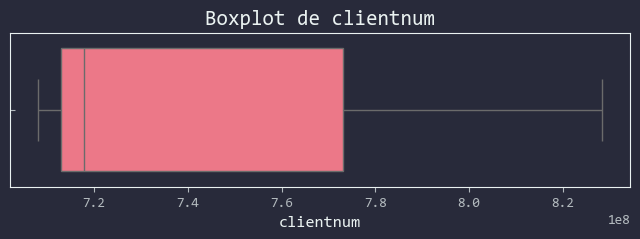

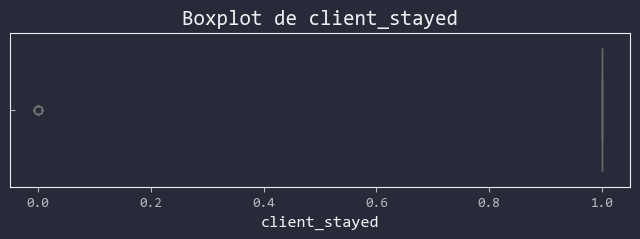

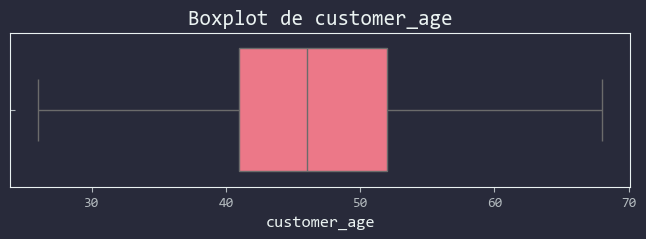

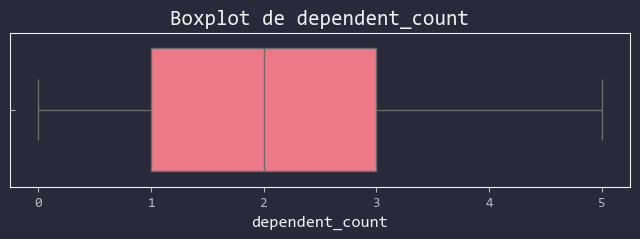

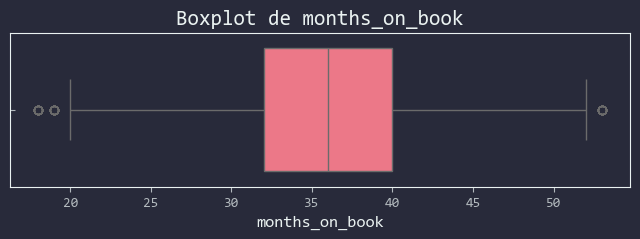

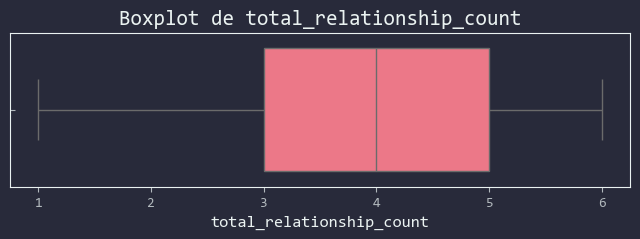

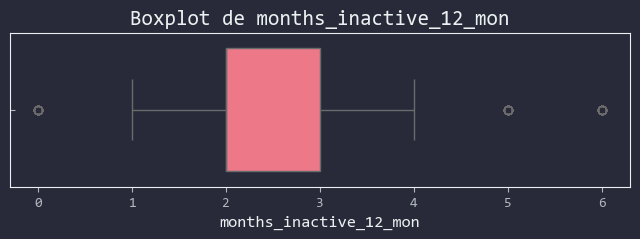

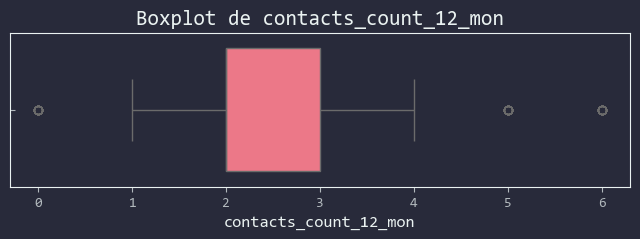

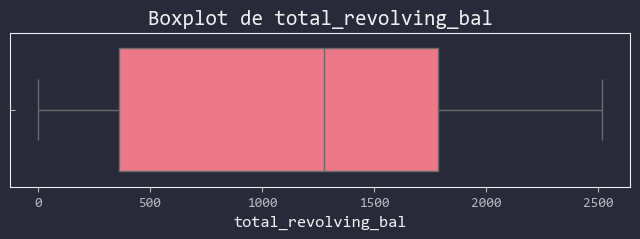

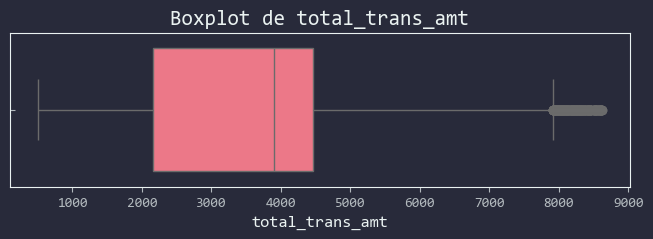

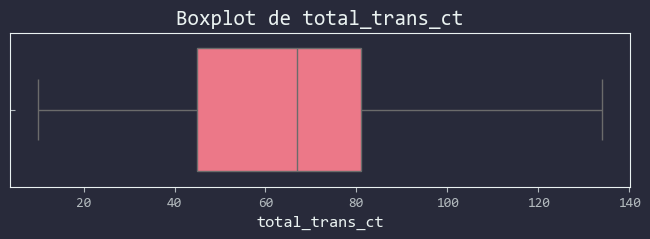

In [70]:
for col in df.columns:
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        plt.figure(figsize=(8, 2))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.xlabel(f'{col}')
        plt.show()
    else:
        continue

In [ ]:

# Verificación

columnas_numericas = ['customer_age', 'months_on_book', 'credit_limit','total_trans_amt','total_trans_ct']

for columna in columnas_numericas:
    # Calcular Q1, Q3 e IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límites para atípicos
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR
    
    valor_reemplazo = df[columna].median()  # Mediana es 12.5 en este caso
    df[columna] = np.where(
        df[columna] > limite_superior,
        valor_reemplazo,
    df[columna]
)

print("Valores únicos después de reemplazo:", df[columna].unique())
print("¿Quedan outliers?", any(df[columna] > limite_superior))   


Valores únicos después de reemplazo: [ 42.  33.  20.  28.  24.  31.  36.  32.  26.  17.  29.  27.  21.  30.
  16.  18.  23.  22.  40.  38.  25.  43.  37.  19.  35.  15.  41.  57.
  12.  14.  34.  44.  13.  47.  10.  39.  53.  50.  52.  48.  49.  45.
  11.  55.  46.  54.  60.  51.  63.  58.  59.  61.  78.  64.  65.  62.
  67.  66.  56.  69.  71.  75.  74.  76.  84.  82.  88.  68.  70.  73.
  86.  72.  79.  80.  85.  81.  87.  83.  91.  89.  77. 103.  93.  96.
  99.  92.  90.  94.  95.  98. 100. 102.  97. 101. 104. 105. 106. 107.
 109. 118. 108. 122. 113. 112. 111. 127. 114. 124. 110. 120. 125. 121.
 117. 126. 134. 116. 119. 129. 131. 115. 128. 123. 130. 132.]
¿Quedan outliers? False


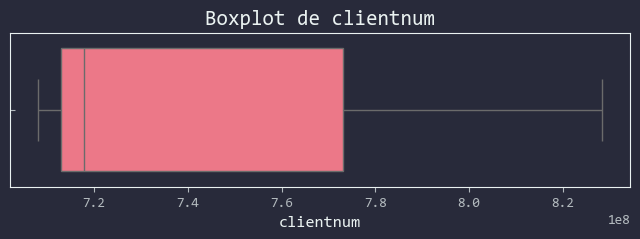

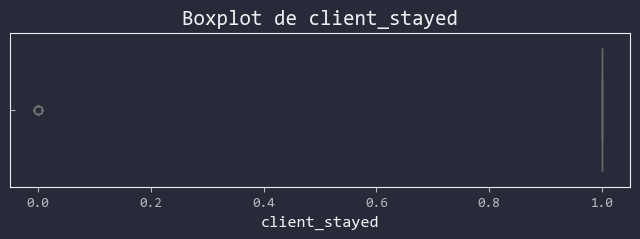

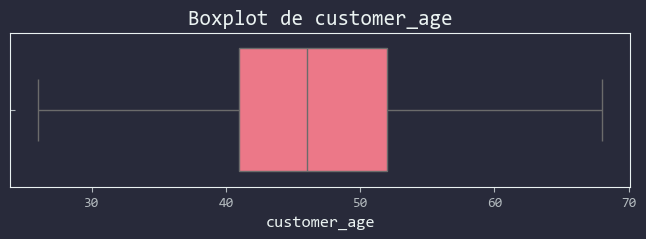

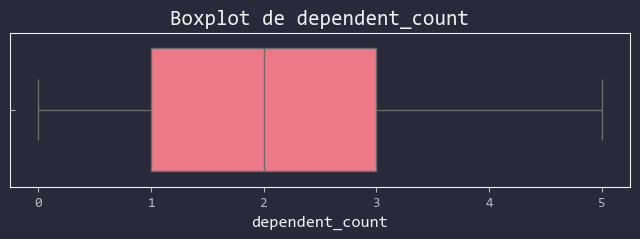

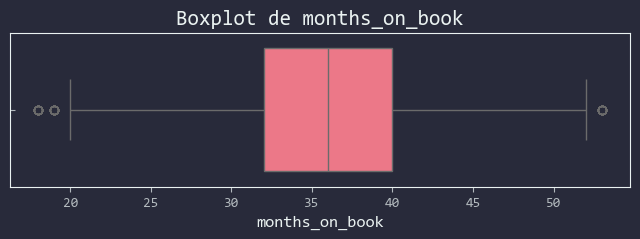

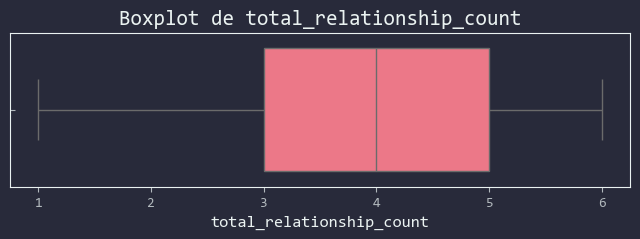

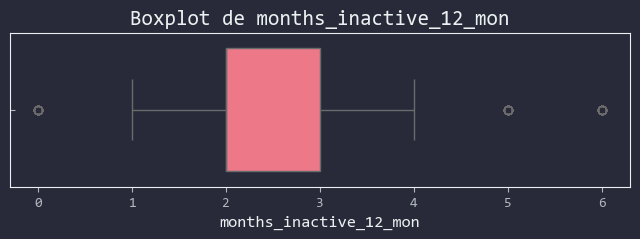

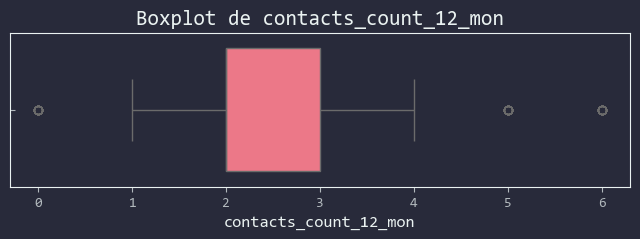

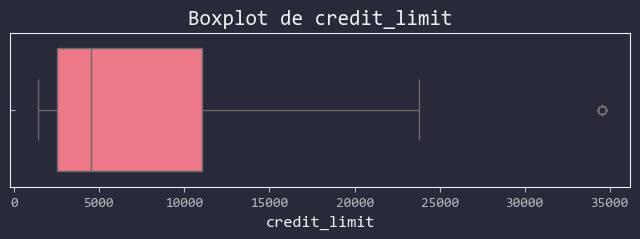

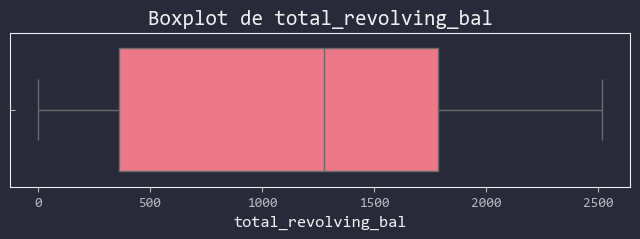

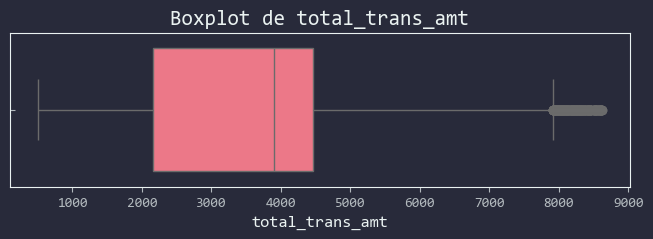

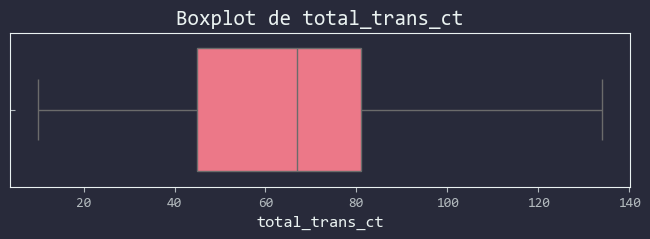

In [73]:
for col in df.columns:
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        plt.figure(figsize=(8, 2))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.xlabel(f'{col}')
        plt.show()
    else:
        continue